<a href="https://colab.research.google.com/github/Sanim27/Torch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import torch.nn as nn
import torch

In [49]:
class CNNNet(nn.Module):
    def __init__(self, num_classes):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),  # Add BatchNorm after Conv
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),  # Add BatchNorm after Conv
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),  # Add BatchNorm after Conv
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Add BatchNorm after Conv
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Add BatchNorm after Conv
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

cnnnet=CNNNet(num_classes=2)



1.   Conv2d
2.   ReLU
3.   MaxPool2d





AdaptiveMaxPool2d and AdaptiveAvgPool2d work independent to the dimensions of incoming input tensor so it is better to use them rather than normal avgpool2d and maxpool2d.

Dropout is randomly turning off some neurons. It should be done only during training. If it is done during prediction then we would just lose some part of network's predicting ability.

In [50]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_path = '/content/images.zip'
extraction_dir = '/content/'  # Extract to root content directory, it will maintain train/, test/, and val/ folders

# Unzip the file, preserving the folder structure
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f"Files extracted to: {extraction_dir}")

Files extracted to: /content/


In [51]:
import torchvision
from torchvision import transforms
train_data_path='./train/'
transforms=transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485,0.456,0.406],
            std=[0.229,0.224,0.225]
            )
    ]
)

train_data=torchvision.datasets.ImageFolder(root=train_data_path,transform=transforms)

In [52]:
val_path='./val/'
test_path='./test/'
val_data=torchvision.datasets.ImageFolder(root=val_path,transform=transforms)
test_data=torchvision.datasets.ImageFolder(root=test_path,transform=transforms)

In [53]:
batch_size=64
train_data_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_data_loader=torch.utils.data.DataLoader(val_data,batch_size=batch_size,shuffle=False)
test_data_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [54]:
import torch.optim as optim
optimizer=optim.Adam(cnnnet.parameters(),lr=0.001)

In [55]:
if torch.cuda.is_available():
  print('cuda')
  device=torch.device('cuda')
else:
  device=torch.device('cpu')
  print('cpu')
cnnnet.to(device)

cuda


CNNNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

In [56]:
import torch.nn.functional as F

In [57]:
def train(model,optimizer,loss_fn,train_loader,val_loader,epochs=20,device='cpu'):
  for epoch in range(epochs):
    training_loss=0.0
    valid_loss=0.0
    model.train()
    for batch in train_loader:
      optimizer.zero_grad()
      inputs,targets=batch
      inputs=inputs.to(device)
      targets=targets.to(device)
      output=model(inputs)
      loss=loss_fn(output,targets)
      loss.backward()
      optimizer.step()
      training_loss+=loss.data.item()
    training_loss/=len(train_loader)

    model.eval()
    num_correct=0
    num_examples=0
    for batch in val_loader:
      inputs,targets=batch
      inputs=inputs.to(device)    # zero_grad() is not needed since model weights are not updated during validation.
      output=model(inputs)
      targets=targets.to(device)
      loss=loss_fn(output,targets)
      valid_loss+=loss.data.item()
      correct = torch.eq(torch.max(output, dim=1)[1], targets).view(-1)

      num_correct += torch.sum(correct).item()
      num_examples+=correct.shape[0]
    valid_loss/=len(val_loader)
    print('Epoch: {}, Training loss: {:.2f}, Validation loss: {:.2f}, accuracy: {:.2f}'.format(epoch,training_loss,valid_loss,num_correct/num_examples))

In [61]:
import os
from PIL import Image
from torchvision import datasets

def remove_corrupted_images(image_folder):
    """
    Removes corrupted images from the given folder and prints the names of corrupted files.
    """
    corrupted_files = []
    # Get a list of all image files in the directory
    all_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

    # Loop through each file in the directory
    for filename in all_files:
        file_path = os.path.join(image_folder, filename)

        # Check if the file is an image
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            try:
                # Try to open the image file
                img = Image.open(file_path)
                img.verify()  # Verify the image integrity
                img.close()   # Close the image after verification
            except (IOError, SyntaxError) as e:
                # If there's an error, append to the list and remove the file
                corrupted_files.append(file_path)
                os.remove(file_path)
                print(f"Corrupted image file removed: {file_path}")

    # Return the list of corrupted files for reference
    return corrupted_files

# Remove corrupted images from both directories
corrupted_cats = remove_corrupted_images('/content/train/cat')
corrupted_fish = remove_corrupted_images('/content/train/fish')
corrupted_val_cats = remove_corrupted_images('/content/val/cat')
corrupted_val_fish = remove_corrupted_images('/content/val/fish')

print(f"Total corrupted train cat images removed: {len(corrupted_cats)}")
print(f"Total corrupted train fish images removed: {len(corrupted_fish)}")
print(f"Total corrupted val cat images removed: {len(corrupted_val_cats)}")
print(f"Total corrupted val fish images removed: {len(corrupted_val_fish)}")

# After removing corrupted images, reinitialize the ImageFolder datasets
def reload_image_folder(train_dir, val_dir, transform):
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=transform)
    return train_dataset, val_dataset

# Example usage assuming transform is defined and applied during the data loading process
train_dataset, val_dataset = reload_image_folder('/content/train', '/content/val', transforms)

# Now you can recreate the DataLoader with the refreshed dataset
from torch.utils.data import DataLoader

train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Total corrupted train cat images removed: 0
Total corrupted train fish images removed: 0
Total corrupted val cat images removed: 0
Total corrupted val fish images removed: 0


In [62]:
train(cnnnet, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, device=device)

Epoch: 0, Training loss: 0.10, Validation loss: 1.96, accuracy: 0.58
Epoch: 1, Training loss: 0.08, Validation loss: 0.82, accuracy: 0.81
Epoch: 2, Training loss: 0.04, Validation loss: 1.71, accuracy: 0.75
Epoch: 3, Training loss: 0.03, Validation loss: 1.32, accuracy: 0.80
Epoch: 4, Training loss: 0.11, Validation loss: 0.83, accuracy: 0.83
Epoch: 5, Training loss: 0.08, Validation loss: 1.21, accuracy: 0.77
Epoch: 6, Training loss: 0.07, Validation loss: 2.10, accuracy: 0.70
Epoch: 7, Training loss: 0.02, Validation loss: 3.94, accuracy: 0.65
Epoch: 8, Training loss: 0.12, Validation loss: 2.39, accuracy: 0.67
Epoch: 9, Training loss: 0.14, Validation loss: 1.19, accuracy: 0.69
Epoch: 10, Training loss: 0.05, Validation loss: 2.21, accuracy: 0.74
Epoch: 11, Training loss: 0.03, Validation loss: 5.16, accuracy: 0.60
Epoch: 12, Training loss: 0.04, Validation loss: 1.06, accuracy: 0.90
Epoch: 13, Training loss: 0.05, Validation loss: 1.98, accuracy: 0.74
Epoch: 14, Training loss: 0.04

In [65]:
from PIL import Image
labels = ['cat','fish']
img = Image.open('/content/train/fish/mysilver.jpg')
img = transforms(img)
img = img.unsqueeze(0)
img = img.to(device)
prediction = cnnnet(img)
prediction = prediction.argmax()
print(labels[prediction])

fish


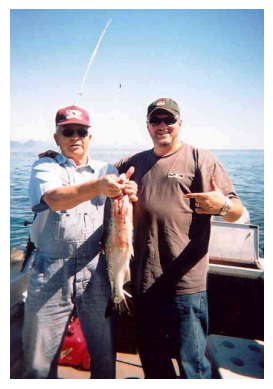

fish


In [70]:
from PIL import Image
import matplotlib.pyplot as plt
labels = ['cat', 'fish']
img_path = '/content/train/fish/717703752_b38872d837.jpg'
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()
img = transforms(img)
img = img.unsqueeze(0).to(device)
cnnnet.eval()
with torch.no_grad():
    prediction = cnnnet(img)
prediction = prediction.argmax(dim=1).item()
print(labels[prediction])